# TRUSTWORTHY AI: Privacy and Data governance Requirement

#### Script to ensure the Privacy and data governance requirement for a dataset. Based on EU guidelines.
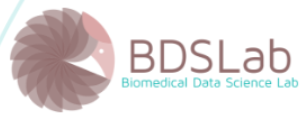


## TABLE OF CONTENTS:

<div class="alert" style="margin-top: 20px">

1. [Data preparation](#data-preparation)<br>
1.1. [Data pre-processing](#data-pre-processing)<br>
1.2. [Data quality control](#data-quality-control)

[References](#references)
</div>


The key requirement of Privacy and data governance covers four main concepts:

* **Privacy and data protection:** protect the information provided by the user and generated by the model. You must not use the data collected illegally or to discriminate unfairly.
*  **Quality and integrity of data:** ensure that data is free from bias and error.
*  **Acces to data:** consider data access protocols. Only qualified personnel should have access.


We start by preparing the working environment. Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

from pca import pca, hotellingsT2
import seaborn as sns
import math

Load the dataset and define Metadata

In [2]:
path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\BECA COLABORACIÓN\\Datasets\\Heart Disease\\' 
file_name = 'dataset_heart_disease_full.xlsx'
data = pd.read_excel(path + file_name)

# Create a subset to work more efficiently
# data = data.sample(frac = 0.1, random_state = 1) 

In [3]:
# Define Metadata
dataset = data
output = "target"
positive_class = ""
feat_id = ""
feat_sensitive = ["sex"]
feat_types = {
    "age": "numerical",
    "sex": "categorical",
    "chest pain type": "categorical",
    "resting bp s": "numerical",
    "cholesterol": "numerical",
    "fasting blood sugar": "categorical",
    "resting ecg": "categorical",
    "max heart rate":"numerical",
    "exercise angina":"categorical",
    "oldpeak":"numerical",
    "ST slope":"categorical",
}
feat2balance = ["sex"]
data_provenance = "The dataset consists of 1190 records of patients from US, UK, Switzerland and Hungary."

In [4]:
### Uncomment only if you want to binarise a multi-class classification problem ###
# class_positive = '<30'
# tags_df = pd.Series(np.where(tags_df == class_positive, 1, 0), index=tags_df.index, name=tags_df.name)

unique_classes = np.unique(dataset[output])
n_classes = len(unique_classes)
feat_num = [col for col, type in feat_types.items() if type == "numerical"]
feat_cat = [col for col, type in feat_types.items() if type == "categorical"]

## 1. DATA PREPARATION  <a class="anchor" id="data-preparation"></a>

### 1.1. Data Pre-processing: <a class="anchor" id="data-pre-processing"></a>

First, we must ensure that the data instances cannot be recognized (`Anonymization`). If you are working with sensitive data, it is important to consider data anonymization. There are various techniques available to ensure data privacy, including randomization or masking, as well as more specific methods such as k-anonymity [1].

In our dataset, two identifying features have been anonymized with individual numbers for each patient and encounter.  However, we do not need this information, so we will be working without these columns.

In [5]:
# feat_id = ["encounter_id","patient_nbr"]
# dataset.drop(feat_id, axis=1, inplace=True)

Furthermore, the information must follow a standard framework (`Standardisation`). Therefore, in our particular case we will convert the Diagnostic Code Description (ICD-9) in 'diag_1', 'diag_2' and 'diag_3' to their corresponding diagnosis [2, 3].

In [6]:
# # Define the categories and ranges to replace
# categories = {
#     'Circulatory': (390, 459),
#     'Digestive': (520, 579),
#     'Genitourinary': (580, 629),
#     'Diabetes': (250),
#     'Injury': (800, 999),
#     'Musculoskeletal': (710, 739),
#     'Neoplasms': (140, 239),
#     'Respiratory': (460, 519),
#     'Other': float('inf')  # Any other Value
# }

# # Function to replace the ICD-9 per the diagnosis
# def replace_category(x, categories):
#     if pd.isna(x):
#         return x
#     try:
#         return next((category for category, value_range in categories.items() if pd.notna(x) and (
#             (isinstance(value_range, int) and float(x) == value_range) or 
#             (isinstance(value_range, tuple) and len(value_range) == 2 and value_range[0] <= float(x) <= value_range[1])
#         )), 'Other')
#     except (ValueError, TypeError): # 'except' to deal with incorrect float conversions (V01-V82.9)
#         return 'Other'

# for col in ['diag_1', 'diag_2', 'diag_3']:
#     dataset[col] = dataset[col].apply(lambda x: replace_category(x, categories))

In [7]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1, random_state = 1)

### 1.2. Data Quality Control: <a class="anchor" id="data-quality-control"></a>

During this stage, it is important to address the Six Data Quality Dimensions (`Data quality control`): completeness, uniqueness, timeliness, validity, accuracy and consistency [4]. Since we lack sufficient information, we will focus on fulfilling the completeness and consistency dimensions.

Consequently, we must address outliers and missing data. Outliers will be addressed using both univariate and multivariate methods. We will then address missing data. It may be helpful to consult the 'Data Provenance' to determine the type of missing data you are dealing with. 

First, it may be useful to set a threshold of missing values above which the feature is deleted, since without enough information the missing imputations are not real.

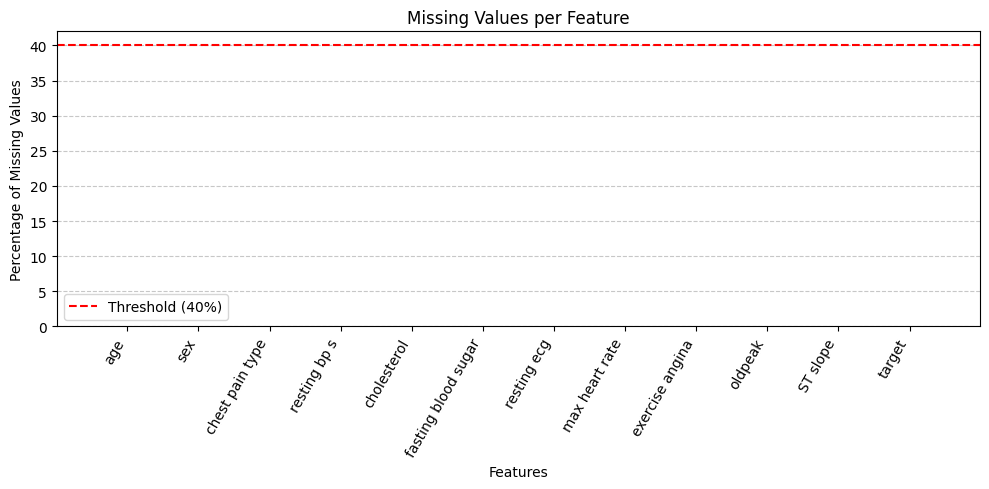

The following features have been removed: .


In [8]:
missing_threshold = 40 # Set an arbitrary threshold

# Calculate percentage of missings by column
missing_array= dataset_train.isnull()
percentage_missing = missing_array.mean() * 100
missing_array[feat_sensitive] = dataset_train[feat_sensitive]
missing_array.to_csv(path + 'missing_array.csv', index=False)
table_missing = pd.DataFrame({'Feature': percentage_missing.index, 'Missing': percentage_missing.values})

plt.figure(figsize=(10, 5)) 
bars = plt.bar(table_missing['Feature'], table_missing['Missing'], color='lightblue')
plt.xticks(rotation=60, ha='right')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.axhline(y=missing_threshold, color='red', linestyle='--', label=f'Threshold ({missing_threshold}%)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Missing Values per Feature')
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

plt.tight_layout()
plt.show()

# Delete columns with missings > missing_threshold
columns_delete = percentage_missing[percentage_missing > missing_threshold].index
print(f"The following features have been removed: {', '.join(columns_delete)}.")

dataset_train.drop(columns=columns_delete, inplace=True)
for column in columns_delete:
    if column in feat_types:
        feat_types.pop(column)
    if column in feat_sensitive:
        feat_sensitive.pop(column)

feat_num = [col for col, type in feat_types.items() if type == "numerical"]
feat_cat = [col for col, type in feat_types.items() if type == "categorical"]

Next, we resolve the univariate outliers.

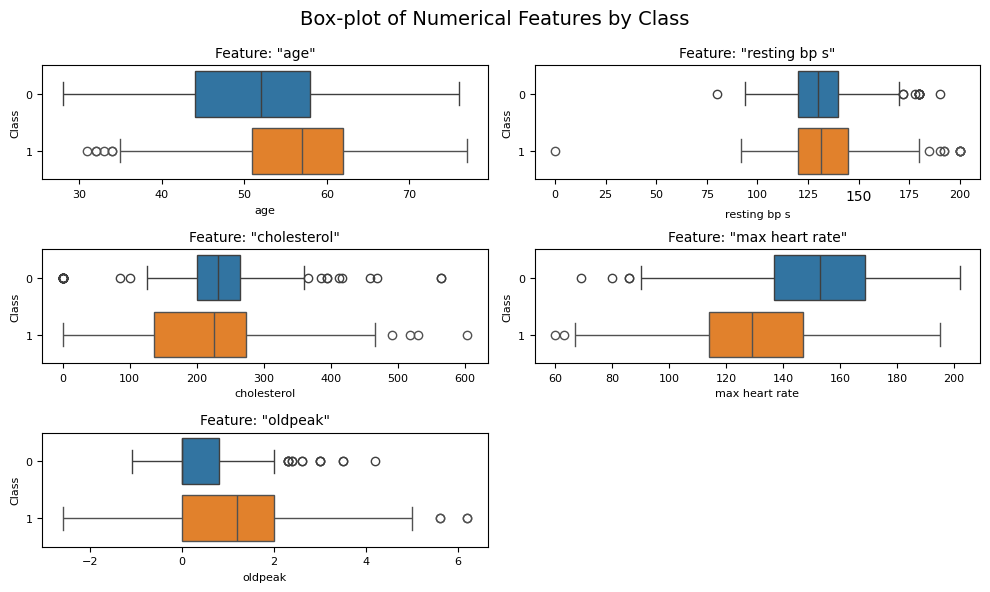

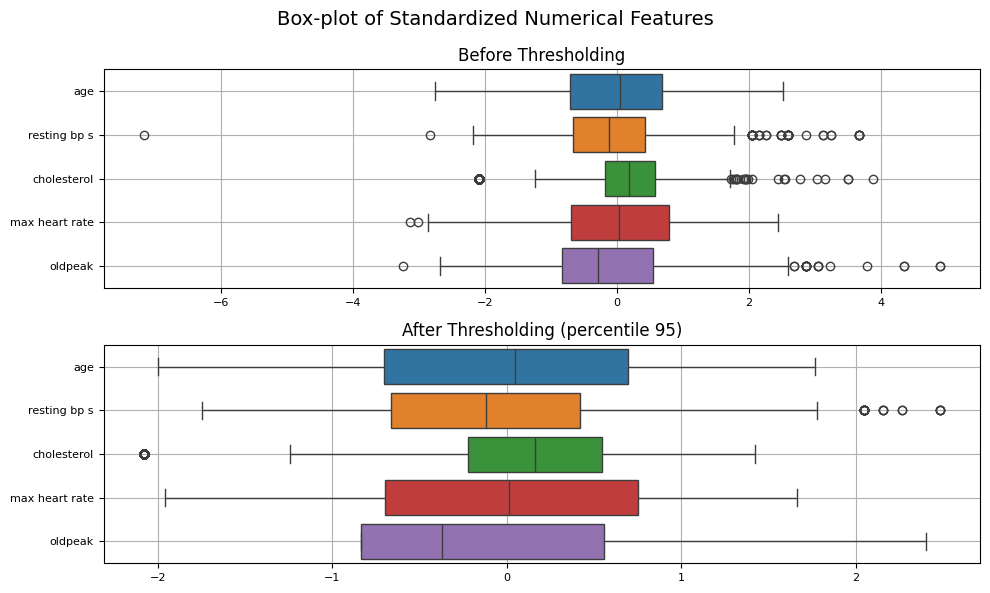

In [9]:
# Create boxplots comparing each numerical feature by class
plt.figure(figsize=(10, 6))
plt.suptitle('Box-plot of Numerical Features by Class', fontsize=14)
for feat in feat_num:
    plt.subplot(math.ceil(len(feat_num)/2), 2, feat_num.index(feat) + 1)
    for class_label in unique_classes:
        class_data = dataset_train.loc[dataset_train[output] == class_label, feat]
        sns.boxplot(y=[class_label]*len(class_data), x=class_data, orient= 'h')
    plt.title(f'Feature: "{feat}"', fontsize=10)
    plt.ylabel('Class', fontsize=8)
    plt.xlabel(feat, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Normalize numerical features
scaler = StandardScaler()
features_num_norm = scaler.fit_transform(dataset_train[feat_num])
features_df_num_norm = pd.DataFrame(features_num_norm, columns=feat_num)

# Calculate the threshold percentile value and convert any outliers to NaN
percentile_threshold = 95
threshold_up = np.percentile(dataset_train[feat_num], percentile_threshold+(100-percentile_threshold)/2, axis=0)
threshold_down = np.percentile(dataset_train[feat_num], (100-percentile_threshold)/2, axis=0)
dataset_train[feat_num] = dataset_train[feat_num].where((dataset_train[feat_num] >= threshold_down) & (dataset_train[feat_num] <= threshold_up), np.nan)

features_num_norm_thres = scaler.transform(dataset_train[feat_num])
features_df_num_norm_thres = pd.DataFrame(features_num_norm_thres, columns=feat_num)

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.boxplot(data=features_df_num_norm, orient= 'h', ax=axs[0])
axs[0].set_title('Before Thresholding', fontsize=12)
axs[0].tick_params(axis='both', labelsize=8)
axs[0].grid(True)

sns.boxplot(data=features_df_num_norm_thres, orient= 'h', ax=axs[1])
axs[1].set_title(f'After Thresholding (percentile {percentile_threshold})', fontsize=12)
axs[1].tick_params(axis='both', labelsize=8)
axs[1].grid(True)

fig.suptitle('Box-plot of Standardized Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

The next step is to impute missing data for those characteristics below the missing threshold. There are different methods for filling in missing values, depending on their origin. They are usually divided into three groups: missing completely at random (MCAR), missing at random (MAR) and missing not at random (MNAR). If we don't have any prior information, our advice is to assume the most common scenario, MNAR. This is the group we will be dealing with.

One of the most common approaches is to implement the Multivariate Imputation by Chained Equations (MICE) method [5]. This method offers a holistic imputation by employing multiple techniques to fill in the missing data and then combines the results to produce a final value.

In [10]:
# Train Linear Regression and KNN Imputers for numerical and categorical features respectively
numImputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)
catImputer = IterativeImputer(estimator=KNeighborsClassifier(), random_state=1, max_iter=10)

# Solve numerical missing
dataset_train[feat_num] = numImputer.fit_transform(dataset_train[feat_num])
dataset_test[feat_num] = numImputer.transform(dataset_test[feat_num])

# Solve categorical missing
ordinal_encoder = OrdinalEncoder()
features_cat_encoded = ordinal_encoder.fit_transform(dataset_train[feat_cat]) # Encode features
dataset_train[feat_cat] = catImputer.fit_transform(features_cat_encoded) # Impute values
dataset_train[feat_cat] = ordinal_encoder.inverse_transform(dataset_train[feat_cat]) # Decode features

features_cat_encoded = ordinal_encoder.transform(dataset_test[feat_cat]) 
dataset_test[feat_cat] = catImputer.transform(features_cat_encoded) 
dataset_test[feat_cat] = ordinal_encoder.inverse_transform(dataset_test[feat_cat])

To complete the data quality control stage, we will remove multivariate outliers. Our approach uses both PCA and Hotelling T2 technique to detect these instances. PCA helps determine the variation across different features, and the Hotelling T2 distribution provides the threshold to control outliers.

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [5] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.00] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[pca] >Cleaning previous fitted model results..
[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.00] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
age --> 1
resting bp s --> 2
cholesterol --> 3
max heart rate --> 4
oldpeak --> 5

Number of outliers deleted: 0


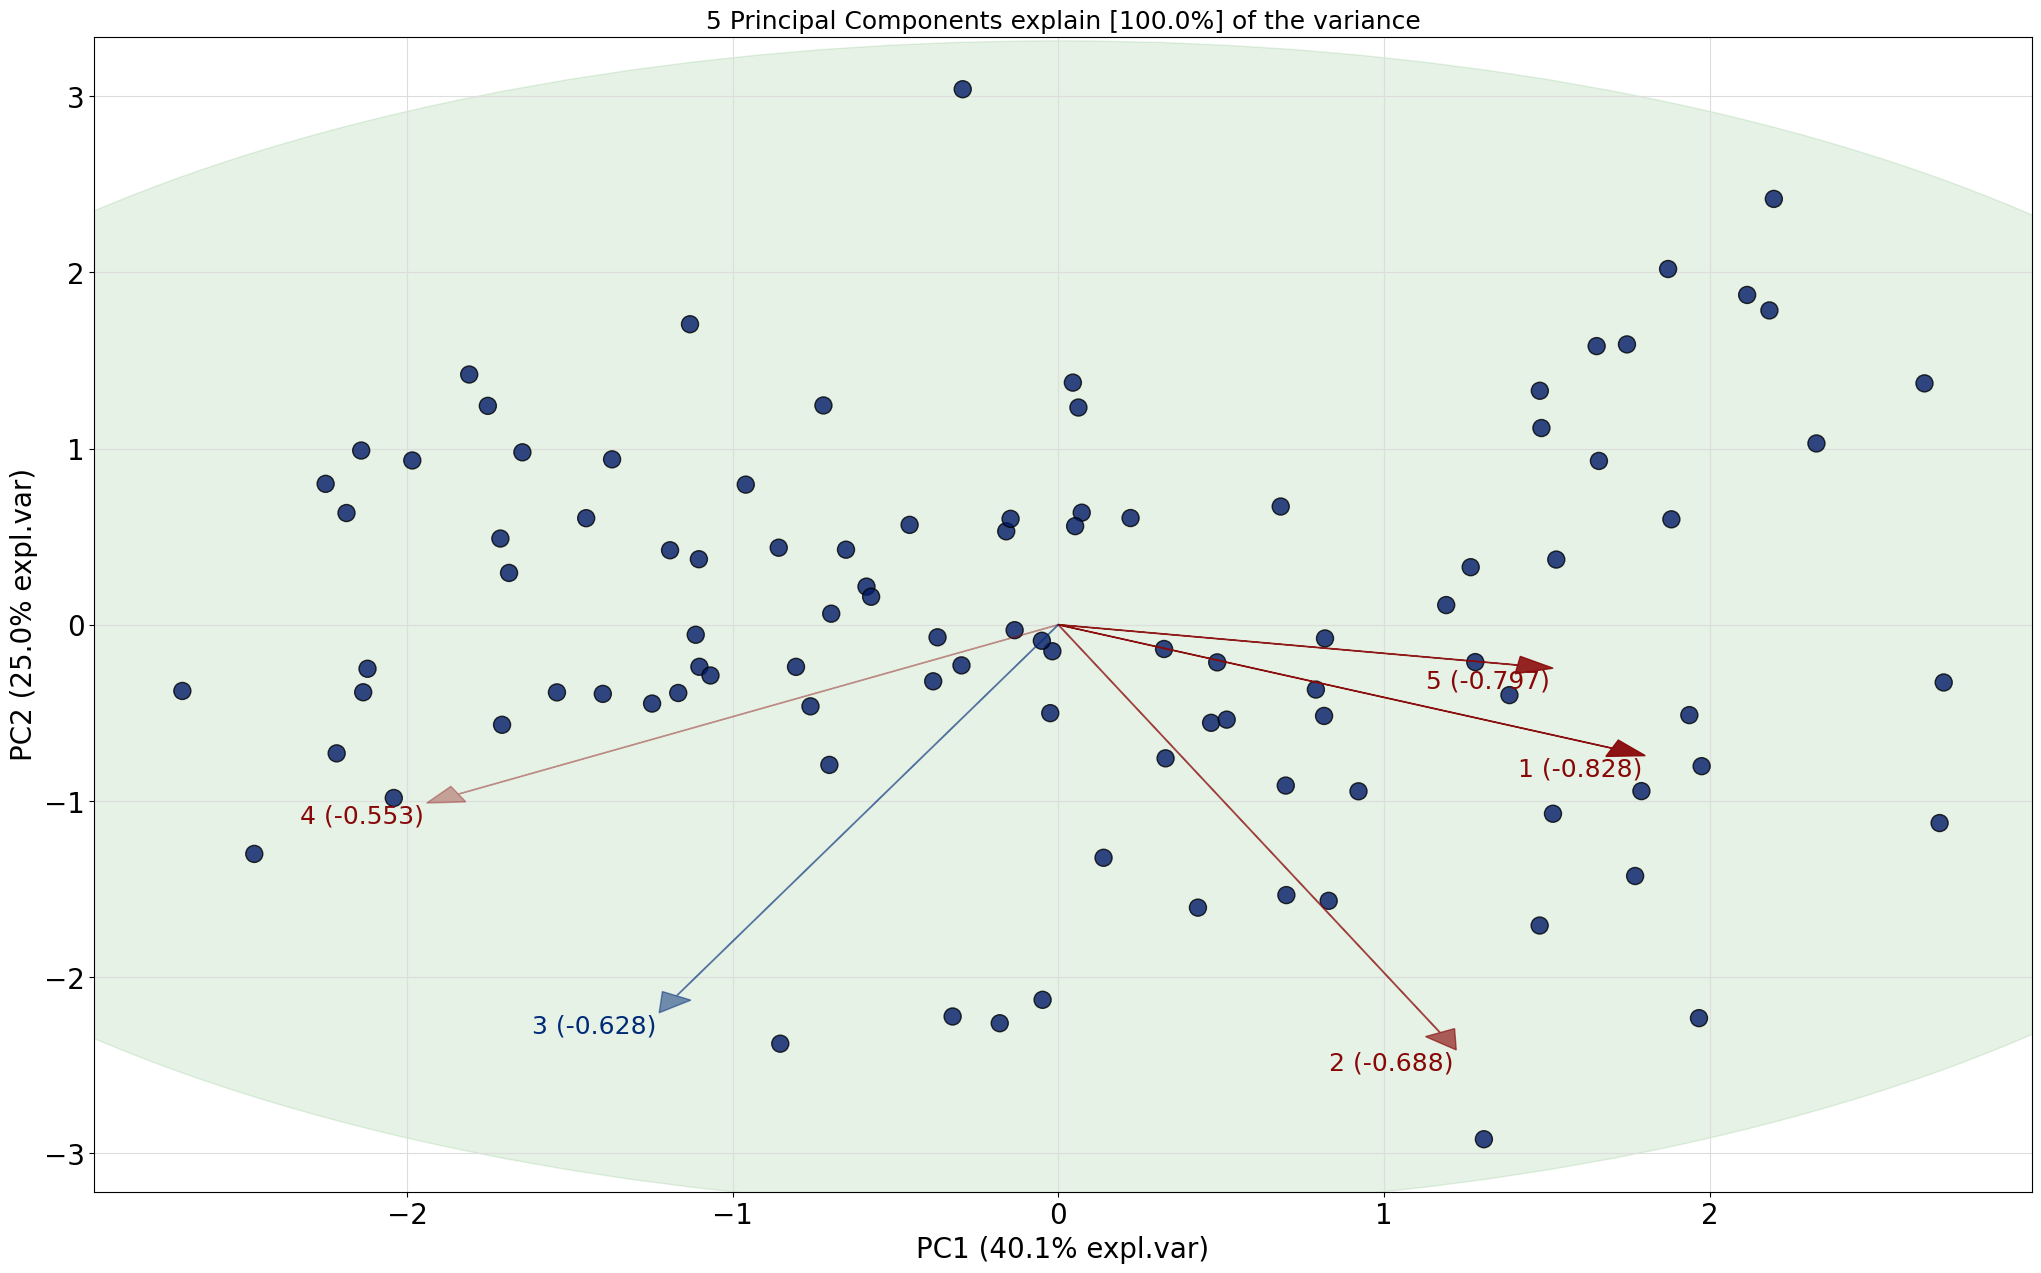

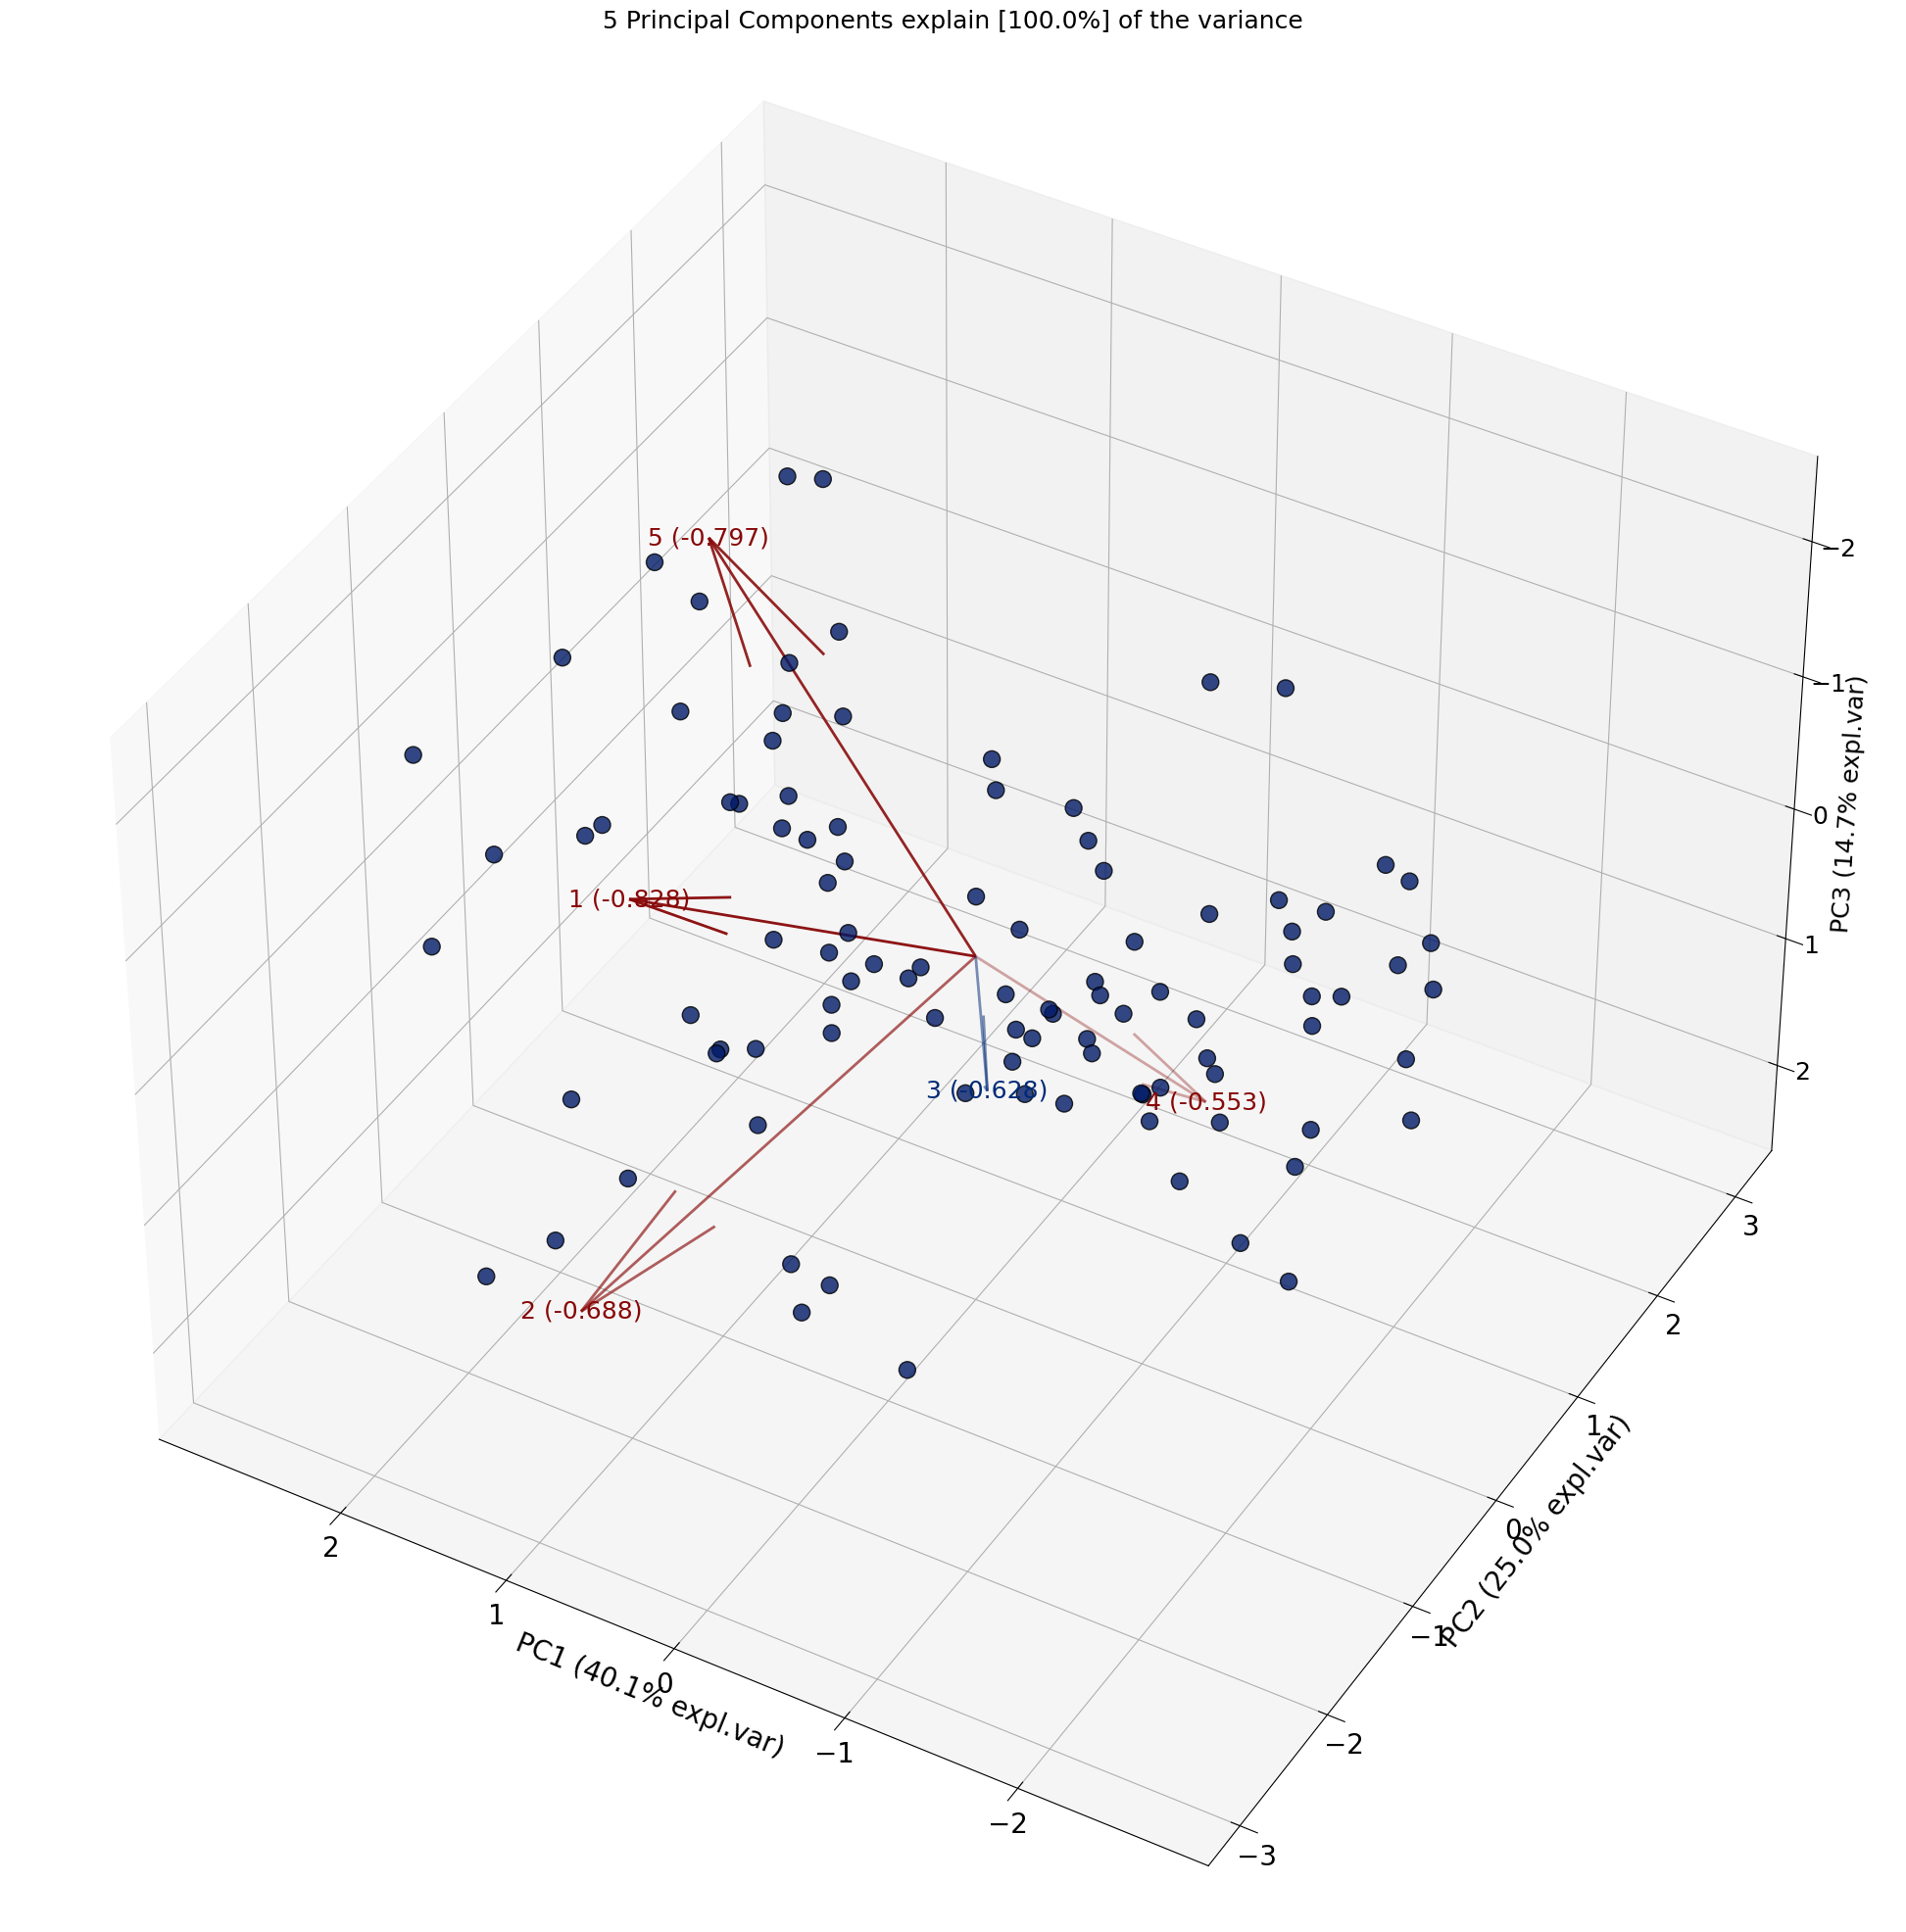

In [11]:
# Calculate the multivariate outliers for numerical features.
features_normalized = scaler.fit_transform(dataset_train[feat_num])

# Initialize the PCA outlier detection model.
model_outliers = pca(alpha=0.01, detect_outliers=['ht2', 'spe'])
results = model_outliers.fit_transform(features_normalized)

### GRAPH A RANDOM SUBSET ###
# Select a random subset
random_idx = np.random.choice(dataset_train.shape[0], size=100, replace=False)
dataset_sample = dataset_train.iloc[random_idx]
features_sample_normalized = scaler.transform(dataset_sample[feat_num])

# Plot the subset and outliers limit
model_outliers.fit_transform(features_sample_normalized)
model_outliers.biplot(legend=True, SPE=True, HT2=True)
model_outliers.biplot3d(legend=True, SPE=True, HT2=True)

# Display the numerical features with their corresponding index.
for i, feature in enumerate(feat_num):
    print(f"{feature} --> {i+1}")

outliers = results['outliers']['y_bool']
outliers_idx = dataset_train.index[outliers]
outliers_multivariate = dataset_train.loc[outliers_idx, :]
outliers_multivariate.to_csv(path + 'outliers_multivariate.csv', index=False)

print("\nNumber of outliers deleted:", len(outliers_idx))
dataset_train.drop(outliers_idx, inplace=True)

At this point, it is possible to use data in a more proper way and make more accurate analyses.

In [12]:
file_name_train = 'dataset_train_heart_disease_QC.csv'
dataset_train.to_csv(path + file_name_train, index=False)

file_name_test = 'dataset_test_heart_disease_QC.csv'
dataset_test.to_csv(path + file_name_test, index=False)

print(f"The data frames are saved as '{file_name_train}' and '{file_name_test}'.")

The data frames are saved as 'dataset_train_heart_disease_QC.csv' and 'dataset_test_heart_disease_QC.csv'.


## REFERENCES  <a class="anchor" id="references"></a>

1. Olatunji, I. E., Rauch, J., Katzensteiner, M., & Khosla, M. (2022). A Review of Anonymization for Healthcare Data. Big Data, big.2021.0169. https://doi.org/10.1089/big.2021.0169 <br>

2. Health, Ministry of. Diagnostic Code Descriptions (ICD-9) - Province of British Columbia. https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9. Accessed 14 Mar. 2024.<br>

3. Strack, Beata, et al. ‘Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records’. BioMed Research International, vol. 2014, 2014, p. 781670. PubMed, https://doi.org/10.1155/2014/781670.<br>

4. Ramasamy, A., & Chowdhury, S. (2020). Big Data Quality Dimensions: A Systematic Literature Review. Journal of Information Systems and Technology Management, e202017003. https://doi.org/10.4301/S1807-1775202017003. <br>

5. Stavseth, Marianne Riksheim, et al. ‘How Handling Missing Data May Impact Conclusions: A Comparison of Six Different Imputation Methods for Categorical Questionnaire Data’. SAGE Open Medicine, vol. 7, Jan. 2019, p. 205031211882291. DOI.org (Crossref), https://doi.org/10.1177/2050312118822912.<br>

